In [1]:
from econ_regime.econ_regime import *
from price.macro_info import get_econ_info
from price.price_processing import *
from strategy.factors.momentum import *
from strategy.factors.volatility import *
from strategy.factors.beta import *
from strategy.optimize.cross_sectional import *
from backtest.metric import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import bs4 as bs
import requests
import datetime as dt
import pickle5 as pickle
import seaborn as sns

In [2]:
sp500_daily_ret = pd.read_csv('result/sp500_daily_rets.csv', index_col=0)
beta_daily_rets = pd.read_csv('result/beta_daily_rets.csv', index_col=0)
mom_daily_rets = pd.read_csv('result/mom_daily_rets.csv', index_col=0)
vol_daily_rets = pd.read_csv('result/vol_daily_rets.csv', index_col=0)

In [3]:
factor_daily_df = pd.concat([sp500_daily_ret, beta_daily_rets, mom_daily_rets, vol_daily_rets], axis=1)
factor_daily_df.columns = ['sp500', 'beta', 'mom', 'vol']

<AxesSubplot: >

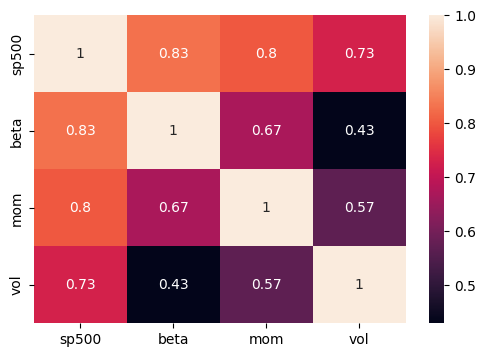

In [4]:
# 상관계수 행렬
corr = factor_daily_df.corr()

# 상관계수 히트맵
plt.figure(figsize=(6, 4))
sns.heatmap(np.round(corr, 2), annot=True)

In [5]:
factor_daily_df.describe()

,sp500,beta,mom,vol
count,2749.000000,2710.000000,2694.000000,2711.000000
mean,0.000522,0.000937,0.000909,0.000470
std,0.010745,0.020991,0.015237,0.008813
min,-0.109424,-0.161498,-0.133985,-0.105230
25%,-0.003616,-0.008965,-0.006537,-0.003271
50%,0.000596,0.001200,0.001755,0.000734
75%,0.005507,0.011359,0.009263,0.004605
max,0.090603,0.173479,0.126021,0.108190


In [6]:
regime_df = pd.read_csv('result/regime_df.csv', index_col=0)

In [7]:
### 일별 수익률을 통해 월별 수익률 만들자
factor_daily_df.index = pd.to_datetime(factor_daily_df.index)
factor_montly_rets = (1 + factor_daily_df).cumprod().ffill().resample('M').last().pct_change().fillna(0)

In [8]:
regime_df = regime_df.loc['2012':]
regime_df.index = pd.to_datetime(regime_df.index)
regime_with_rets = pd.concat([regime_df, factor_montly_rets], axis=1)

In [9]:
regime_with_rets

,deflation,inflation,recovery,expansion,recession,sp500,beta,mom,vol
2012-01-31,0.0,0.0,1.0,0.0,0,0.000000,0.000000,0.000000,0.000000
2012-02-29,0.0,0.0,1.0,0.0,0,0.043405,0.075576,0.000000,0.015604
2012-03-31,0.0,0.0,1.0,0.0,0,0.032164,0.042314,0.000000,0.022668
2012-04-30,0.0,0.0,1.0,0.0,0,-0.006675,-0.046182,0.000000,0.016248
2012-05-31,1.0,0.0,0.0,0.0,0,-0.060056,-0.138476,-0.049723,-0.001422
...,...,...,...,...,...,...,...,...,...
2022-08-31,0.0,1.0,0.0,0.0,0,-0.040802,-0.074117,0.033443,-0.018260
2022-09-30,0.0,1.0,0.0,0.0,0,-0.092446,-0.123582,-0.085286,-0.090193
2022-10-31,0.0,1.0,0.0,0.0,0,0.081276,0.036819,0.191928,0.077215
2022-11-30,0.0,1.0,0.0,0.0,0,0.055592,0.085142,0.011070,0.033541


In [10]:
def factor_regime_hist(regime_with_rets_df, regime: str, factor: str):
    """
    시황별 factor 수익률 분포를 히스토그램으로 그려준다
    """
    plt.figure(figsize=(5, 3))
    
    target_bins = 1\
                + round(
                np.log(
                len(
                regime_with_rets_df\
                [regime_with_rets_df[regime] == 1]
                    )
                )
            )
    
    sns.histplot(
            regime_with_rets_df\
            .loc[regime_with_rets_df[regime] == 1, factor], 
            bins=target_bins
                )

    plt.title(f'{regime} {factor} factor returns')
    plt.show()

In [11]:
def factor_regime_stats(regime_with_rets_df: pd.DataFrame, regime_list: list, factor_list: list):

    best_sharp = {}
    for regime in regime_list:
        
        temp_dict = {}
        for factor in factor_list:
            df = regime_with_rets_df.loc[regime_with_rets_df[regime] == 1, factor]
            stats = df.describe().to_dict()
            stats['Sharpe'] = stats['mean'] / stats['std']
            temp_dict[factor] = stats
            print(f'{regime}: {factor} stats')
            print(pd.Series(stats))
            print()
            
        best_sharp[regime] = temp_dict
        
    return best_sharp

def regime_best_sharpe(best_sharp: dict, regime_list: list, factor_list: list):
    """
    시황별 sharpe ratio가 가장 높은 factor를 찾아준다
    """
    best_sharpe_dict = {}
    for regime in regime_list:
        temp_dict = {}
        for factor in factor_list:
            temp_dict[factor] = best_sharp[regime][factor]['Sharpe']
            
        best_sharpe_dict[regime] = temp_dict
        
    best_sharpe_df = pd.DataFrame(best_sharpe_dict)
    best_sharpe_df = best_sharpe_df.T
    best_sharpe_df['best_sharpe'] = best_sharpe_df.idxmax(axis=1)
    best_sharpe_df['best_sharpe_ratio'] = best_sharpe_df.max(axis=1)
    
    return best_sharpe_df

In [12]:
regime_list = ['recovery', 'expansion', 'deflation', 'inflation']
factor_list = ['sp500', 'beta', 'mom', 'vol']

In [13]:
test = factor_regime_stats(regime_with_rets, regime_list, factor_list)

recovery: sp500 stats
count     34.000000
mean       0.017992
std        0.028867
min       -0.037444
25%        0.001211
50%        0.015562
75%        0.036403
max        0.108777
Sharpe     0.623274
dtype: float64

recovery: beta stats
count     34.000000
mean       0.043554
std        0.067584
min       -0.074663
25%       -0.000328
50%        0.036029
75%        0.071755
max        0.289693
Sharpe     0.644442
dtype: float64

recovery: mom stats
count     34.000000
mean       0.024202
std        0.036934
min       -0.053845
25%        0.000000
50%        0.020847
75%        0.044928
max        0.129068
Sharpe     0.655260
dtype: float64

recovery: vol stats
count     34.000000
mean       0.010100
std        0.026082
min       -0.045138
25%       -0.004658
50%        0.008779
75%        0.027875
max        0.071068
Sharpe     0.387216
dtype: float64

expansion: sp500 stats
count     32.000000
mean       0.017775
std        0.024022
min       -0.036361
25%        0.006855
50%       

In [14]:
regime_best_sharpe(test, regime_list, factor_list)

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24357/2940872178.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_sharpe_df['best_sharpe_ratio'] = best_sharpe_df.max(axis=1)


,sp500,beta,mom,vol,best_sharpe,best_sharpe_ratio
recovery,0.623274,0.644442,0.655260,0.387216,mom,0.655260
expansion,0.739950,0.607937,0.617966,0.297021,sp500,0.739950
deflation,0.148670,0.071996,0.129150,0.220687,vol,0.220687
inflation,-0.071194,-0.192787,0.078694,-0.023976,mom,0.078694


In [15]:
invest_price = (1 + factor_daily_df).cumprod().ffill()
invest_price = add_cash(invest_price, 252, 0.04)
invest_price

,sp500,beta,mom,vol,CASH
date_time,,,,,
2012-04-02,1.084843,1.121088,1.000000,1.038626,1.007008
2012-04-03,1.080407,1.109693,1.006008,1.037143,1.007168
2012-04-04,1.069699,1.085359,0.994809,1.035356,1.007328
2012-04-05,1.069164,1.080178,1.000145,1.033318,1.007488
2012-04-09,1.057156,1.055321,0.991239,1.025557,1.007648
...,...,...,...,...,...
2022-12-23,3.588659,6.866993,8.538557,3.246341,1.546014
2022-12-27,3.574508,6.719505,8.548790,3.253113,1.546259
2022-12-28,3.530084,6.675271,8.345485,3.223930,1.546504


In [16]:
rebal_list = rebal_dates(invest_price, period='month')
rebal_price_df = price_on_rebal(invest_price, rebal_list)

In [17]:
regime_with_rets.drop(['recession'], axis=1, inplace=True)

In [18]:
regime_asset_dict = {'recovery': 'mom', 
                    'expansion': 'beta', 
                    'deflation': 'vol', 
                    'inflation': 'mom'
                    }

In [19]:
regime_with_rets
regime_signal_df = regime_signal(regime_with_rets, regime_asset_dict)
regime_signal_df.sum(axis=1).sum()

132

In [20]:
regime_weight = Equalizer(signal=regime_signal_df, price_df=factor_daily_df, select_period='month',call_method='ew').weight()
regime_weight = regime_weight.fillna(0)
regime_weight.sum(axis=1).sum()

KeyError: "[Timestamp('2013-03-28 00:00:00'), Timestamp('2013-06-28 00:00:00'), Timestamp('2013-08-30 00:00:00'), Timestamp('2013-11-29 00:00:00'), Timestamp('2014-05-30 00:00:00'), Timestamp('2014-08-29 00:00:00'), Timestamp('2014-11-28 00:00:00'), Timestamp('2015-01-30 00:00:00'), Timestamp('2015-02-27 00:00:00'), Timestamp('2015-05-29 00:00:00'), Timestamp('2015-10-30 00:00:00'), Timestamp('2016-01-29 00:00:00'), Timestamp('2016-04-29 00:00:00'), Timestamp('2016-07-29 00:00:00'), Timestamp('2016-12-30 00:00:00'), Timestamp('2017-04-28 00:00:00'), Timestamp('2017-09-29 00:00:00'), Timestamp('2017-12-29 00:00:00'), Timestamp('2018-03-29 00:00:00'), Timestamp('2018-06-29 00:00:00'), Timestamp('2018-09-28 00:00:00'), Timestamp('2019-03-29 00:00:00'), Timestamp('2019-06-28 00:00:00'), Timestamp('2019-08-30 00:00:00'), Timestamp('2019-11-29 00:00:00'), Timestamp('2020-02-28 00:00:00'), Timestamp('2020-05-29 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2021-01-29 00:00:00'), Timestamp('2021-02-26 00:00:00'), Timestamp('2021-05-28 00:00:00'), Timestamp('2021-07-30 00:00:00'), Timestamp('2021-10-29 00:00:00'), Timestamp('2022-04-29 00:00:00'), Timestamp('2022-07-29 00:00:00'), Timestamp('2022-12-30 00:00:00')] not in index"

In [ ]:
regime_port = calculate_portvals(price_df=invest_price, 
                                weight_df=regime_weight, 
                                signal_df=regime_signal_df, 
                                long_only=True)

In [ ]:
Metric((1 + factor_daily_df['sp500']).cumprod().ffill()).numeric_metric()

In [ ]:
port_rets(regime_port, True).plot(lw=1)
Metric(portfolio=port_rets(regime_port, True)).print_report()